In [2]:
%pip install awswrangler --quiet

from re import sub 
from functools import partial
import pandas as pd
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import boto3
import awswrangler as wr

session = boto3.Session()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
panel 0.13.1 requires bokeh<2.5.0,>=2.4.0, but you have bokeh 3.3.0 which is incompatible.
spyder 5.3.3 requires ipython<8.0.0,>=7.31.1, but you have ipython 8.16.1 which is incompatible.
spyder 5.3.3 requires pylint<3.0,>=2.5.0, but you have pylint 3.0.1 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# you need to change this `s3_output` to a directory/S3 bucket that you have permissions to access
s3_output='s3://universityose-bucket/yvlcmb/awswrangler/'

fetch = partial(wr.athena.read_sql_query, 
                database='universityose_db', 
                boto3_session=session,
                s3_output=s3_output)

cols = {
    "flightid": "flightid",
    "times_seconds":"seconds",
    "engines_computations_e1torque": "e1torque",
    "engines_computations_e2torque": "e2torque",
    "flightstate_altitudes_gpsaltitude":"altitude",
    "rotors_mainrotorrpmpercentage": "rotor_rpm",
    "flightstate_rates_climbordescentrate":"climb_descent"
}

def create_sql_from_flightid(flightid, cols=cols):
    sql_query = ''.join((
        'SELECT ', 
        *[f'{k} AS {v}, ' for k, v in cols.items()], 
        "FROM flight_details ", 
        f"WHERE flightid = '{flightid}'"))
    return sub(', FROM', ' FROM', sql_query)

def fetch_flight(flightid: str) -> 'DataFrame':
    """Query a flight from Athena using a flightid,
    return the result as  a Pandas Dataframe, sorted
    by seconds, with vertical acceleration calculated"""
    fix = fetch(create_sql_from_flightid(flightid))
    df = fix.sort_values('seconds').reset_index()
    assert (df.seconds.min() == df.at[0, 'seconds'] and 
            df.seconds.max() == df.iloc[-1].seconds)
    df['vert_accel'] = (
        (df.climb_descent - df.climb_descent.shift(1)) / 
        (df.seconds - df.seconds.shift(1))
    )
    return df[df.columns[1:]]

In [4]:
# below is the result of manually labeling data by looking at flight sub plots
# this dictionary contains flightids as keys and tuples of integers representing 
# the ranges of rows where low-g occurred as values
# ...using (None) as a second item in the value if there are no other ranges 
# is an ugly work-around that needs to be updated 

flights_and_events= {
    "31dcb8_20230216T191746_20230216T192349": (
        (10600, 11000), 
        (None)
    ),
    "31dcb8_20230615T200220_20230615T201354": (
        (19500, 19700), 
        (None)
    ),
    "31dcb8_20230216T151400_20230216T152827": (
        (34800, 34925), 
        (28350, 28700)
    ),
    "31dcb8_20221020T164314_20221020T170607": (
        (7400, 7700),
        (16150, 16300),
        (23900, 24300),
        (36050, 36200), 
        (50500, 51000)
    ),
    "31dcb8_20221006T134902_20221006T141008": (
        (6120, 6190),
        (43000, 43150), 
        (45600, 45825), 
        (46950, 47075),
        (55550, 55675),
        (51100, 51275)
    ),
    "31dcb8_20230615T193227_20230615T200139": (
        (51100, 51400), 
        (33600, 33950), 
        (13700, 13900), 
        (26425, 26600), 
        (20350, 20500), 
        (44850, 44925),
        (61100, 61250)
    ), 
    "31dcb8_20230615T160258_20230615T163145": (
        (10150, 10550),
        (12800, 13100),
        (14600, 14900),
        (15300, 15600),
        (18400, 18725),
        (19090, 19200),
        (22250, 22500),
        (23040, 23250),
        (43800, 44300), 
        (44800, 45200)
    ),
    "31dcb8_20230615T145234_20230615T152543": (
        (64800, 65100), 
        (None)
    ),
    "31dcb8_20221006T131452_20221006T134556": (
        (22500, 22900), 
        (47350, 47550), 
        (50600, 50700),
        (77300, 77600)
    ),
    "31dcb8_20221020T211929_20221020T220157": (
        (20200, 20800),
        (24725, 24825),
        (28550, 28650),
        (30400, 30700), 
        (41500, 41700)
    ),
    "31dcb8_20221006T145214_20221006T153158": (
        (41250, 41500), 
        (46300, 46700), 
        (36600, 36800), 
        (39180,39400)
    ),
    "31dcb8_20230126T205028_20230126T205649": (
        (14200, 14450), 
        (None)
    ),
    "31dcb8_20230615T133129_20230615T135220": (
        (29350, 29600), 
        (31550, 31700), 
        (34350, 34500)
    )
}

## Assemble Training Data

In [5]:
frames = [fetch_flight(flightid) for flightid in flights_and_events.keys()]

first = lambda seq: seq[0]; last = lambda seq: seq[-1]

for frame in frames: 
    frame['label'] = 0
    ranges = flights_and_events.get(frame.at[0, "flightid"])
    for r in ranges: 
        if r: 
            for i in range(first(r), last(r)+1):
                frame.at[i, 'label'] = 1
                
event_count = sum(1 for val in flights_and_events.values() for v in val)
label_count = sum([frame.label.sum() for frame in frames])
not_label_count = sum([len(frame[frame['label']==0]) for frame in frames])
total_count = sum([len(frame) for frame in frames])

print(f'There are {event_count} low-G events from {len(flights_and_events.keys())} flights')
print(f'There are {label_count} labeled rows from a total of {total_count}.')
print(f'\tLabeled rows: {round((label_count/total_count) * 100, 2)}%')
print(f'\tNon-labeled rows: {round((not_label_count/total_count) * 100, 2)}%')            

There are 54 low-G events from 13 flights
There are 12460 labeled rows from a total of 780457.
	Labeled rows: 1.6%
	Non-labeled rows: 98.4%


## Train the Random Forest

In [8]:
scaler = StandardScaler()
combined = pd.concat(frames)
keep = [
    'climb_descent', 
    'vert_accel',
    'rotor_rpm', 
    'e1torque', 
    'e2torque', 
    'altitude',
    'label',
]
combined = combined[keep].dropna()
df = combined.reset_index(drop=True)
# define independent variables and dependent variable
y = df['label']

# create training set and testing set
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), 
                                                    df['label'],
                                                    test_size=0.3, # 70/30 split
                                                    stratify=y, 
                                                    random_state=1)

X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.fit(X_test).transform(X_test)

In [9]:
# this is the best model identified out of a possible 157 different moduels tested using a Grid Search CV
# which included adaboost, gradient boost, mlcp, svc, linear learner with sgd, and svc linear
clf = ensemble.RandomForestClassifier(max_features='log2', n_estimators=150, n_jobs=-1, random_state=1)
clf.fit(X_train, y_train)  # fit on the entire dataset: 780k rows from 13 flights and 52 low-g events

RandomForestClassifier(max_features='log2', n_estimators=150, n_jobs=-1,
                       random_state=1)

In [10]:
# training results 
y_train_pred = clf.predict(X_train)
print(*zip(
    ('train accuracy:',
     'train recall:', 
     'train precision:',
     'train f1:'),
    (round(metrics.accuracy_score(y_train, y_train_pred), 3),
     round(metrics.recall_score(y_train, y_train_pred), 3),
     round(metrics.precision_score(y_train, y_train_pred), 3),
     round(metrics.f1_score(y_train, y_train_pred), 3))), 
    sep='\n')
# testing results 
y_pred = clf.predict(X_test)
print(*zip(
    ('test accuracy:',
     'test recall:', 
     'test precision:',
     'test f1:'),
    (round(metrics.accuracy_score(y_test, y_pred), 3),
     round(metrics.recall_score(y_test, y_pred), 3),
     round(metrics.precision_score(y_test, y_pred), 3),
     round(metrics.f1_score(y_test, y_pred), 3))), 
    sep='\n')

('train accuracy:', 1.0)
('train recall:', 1.0)
('train precision:', 1.0)
('train f1:', 1.0)
('test accuracy:', 0.998)
('test recall:', 0.911)
('test precision:', 0.987)
('test f1:', 0.948)


## Make Predictions

In [11]:
## now predict new values from an unlabeled flight
flight_ids = fetch("SELECT DISTINCT(flightid) FROM flight_details WHERE month='10' AND year='2023'").flightid.tolist()
df = fetch_flight(flight_ids[0]) # get the most recent flight from October 2023 to predict on

In [12]:
scaler = StandardScaler()
keep = [
    'climb_descent', 
    'vert_accel',
    'rotor_rpm', 
    'e1torque', 
    'e2torque', 
    'altitude',
]
temp = df[keep].dropna() 
X_train = scaler.fit(temp).transform(temp)

y_train_pred = clf.predict(X_train) # make predictions
out = temp.copy()
out['prediction'] = y_train_pred # add them back to the dataframe 
len(out[out.prediction==1]) # total number of low-g rows detected 

816

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

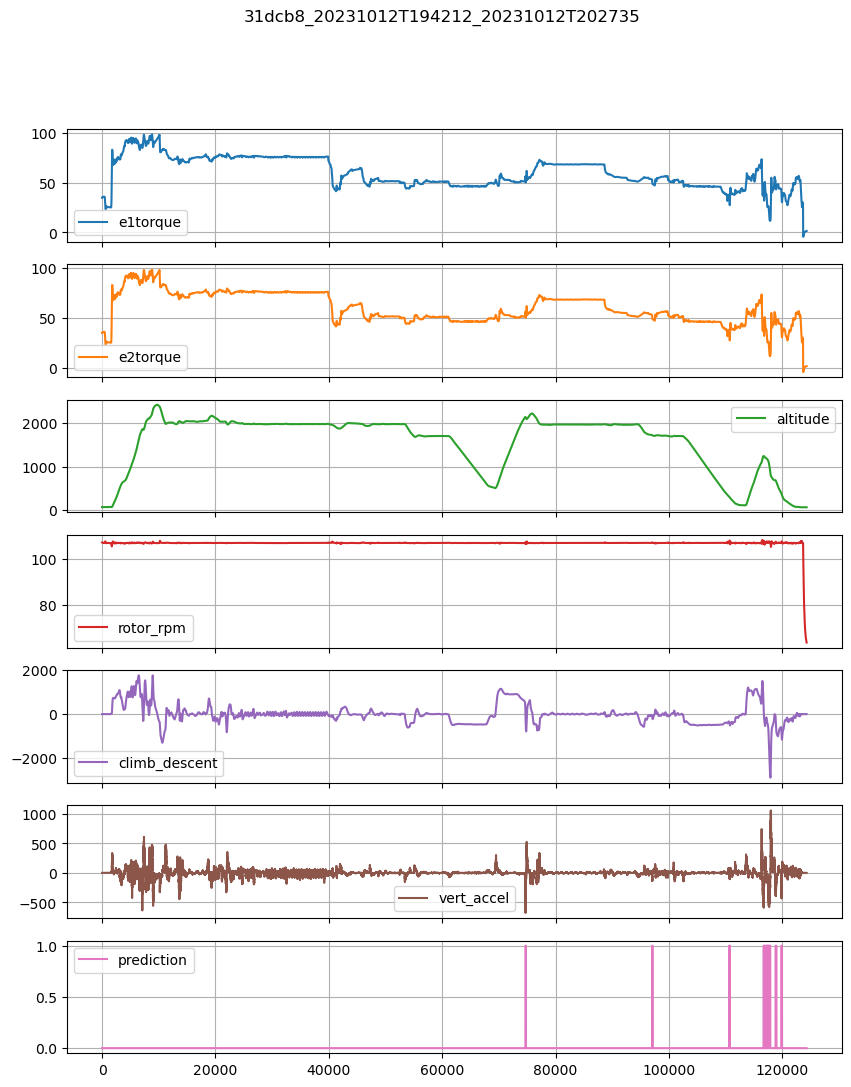

In [13]:
plot_these = ['e1torque', 'e2torque', 'altitude', 'rotor_rpm', 'climb_descent', 'vert_accel', 'prediction']
out[plot_these].plot(subplots=True, grid=True, figsize=(10,12), title=flight_ids[0])

In [14]:
def plot_suspect(frame, rows):
    """Zoom in to specific rows of a dataframe to plot
    
    Parameters
    ----------
    rows: a tuple/list/set indicating start & stop range of rows to plot
    
    Example
    -------
    >>> plot_suspect(frame=df, rows=(43800, 44500))
    """
    frame[rows[0]:rows[1]][plot_these].plot(
    title=flight_ids[0],
    subplots=True,
    grid=True,
    figsize=(10,12))

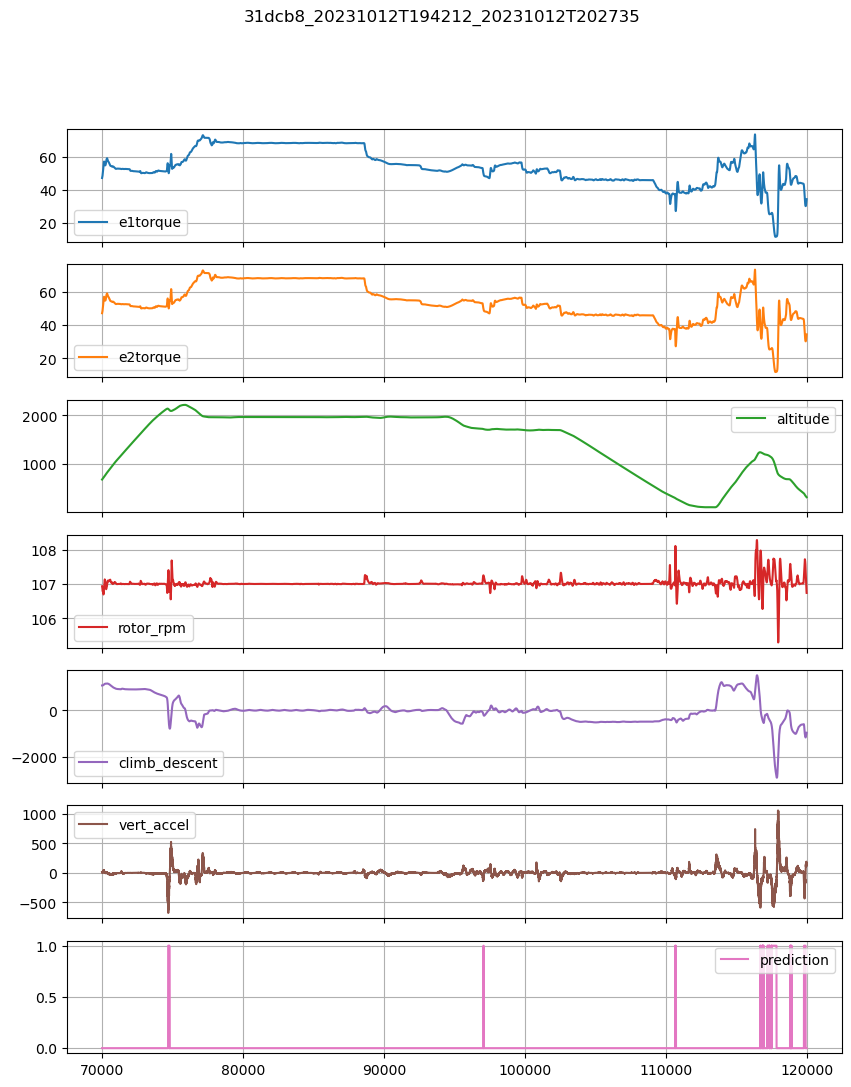

In [15]:
plot_suspect(out, (70000, 120000))

In [16]:
## now predict low-G in several flights simultaneously
new_flight_ids = fetch("SELECT DISTINCT(flightid) FROM flight_details WHERE month IN ('08', '09', '10') AND year='2023'").flightid.tolist()
new_flights = list(map(fetch_flight, new_flight_ids)) 

In [19]:
def predict_events(frame, classifier) -> 'DataFrame': 
    '''Predict low-g events in a dataframe of 
    helicopter flight recorder data from the 
    RAISE `flight_details` table. This should have
    the following columns: 
        "flightid" as "flightid"
        "times_seconds" as "seconds"
        "engines_computations_e1torque" as "e1torque"
        "engines_computations_e2torque" as "e2torque"
        "flightstate_altitudes_gpsaltitude" as "altitude"
        "rotors_mainrotorrpmpercentage" as "rotor_rpm"
        "flightstate_rates_climbordescentrate" as"climb_descent"
    Additionally there needs to be a a vert_accel column
    
    Parameters:
        frame: a dataframe with the columns listed above
        
        classifier: a fitted classifier     
    '''
    scaler = StandardScaler()
    keep = [
        'climb_descent', 
        'vert_accel',
        'rotor_rpm', 
        'e1torque', 
        'e2torque', 
        'altitude',
    ]
    
    temp = frame[keep].dropna() 
    X_train = scaler.fit(temp).transform(temp)
    y_train_pred = classifier.predict(X_train) # make predictions
    out = temp.copy()
    out['prediction'] = y_train_pred
    # add them back to the dataframe 
    print(f'Total rows of low-G predicted: {len(out[out.prediction==1])}')
    _columns = ['Climb/Descent Rate (fps)',
                'Vertical Acceleration (fps)', 
                'Rotor RPM', 
                'Engine 1 torque (Nm)',
                'Engine 2 torque (Nm)',
                'GPS Altitude (ft. AGL)', 
                'Prediction']
    out.columns=_columns
    out[_columns].plot(subplots=True, 
                         grid=True, 
                         figsize=(10,12), 
                         title=frame.at[0, 'flightid'])
    return out

In [32]:
sum(len(x) for x in new_flights) # total number of rows 

1953051

Total rows of low-G predicted: 593
Total rows of low-G predicted: 1931
Total rows of low-G predicted: 151
Total rows of low-G predicted: 816
Total rows of low-G predicted: 1248
Total rows of low-G predicted: 179
Total rows of low-G predicted: 1802
Total rows of low-G predicted: 785
Total rows of low-G predicted: 1036
Total rows of low-G predicted: 1314
Total rows of low-G predicted: 1708
Total rows of low-G predicted: 661
Total rows of low-G predicted: 383
Total rows of low-G predicted: 602
Total rows of low-G predicted: 2396


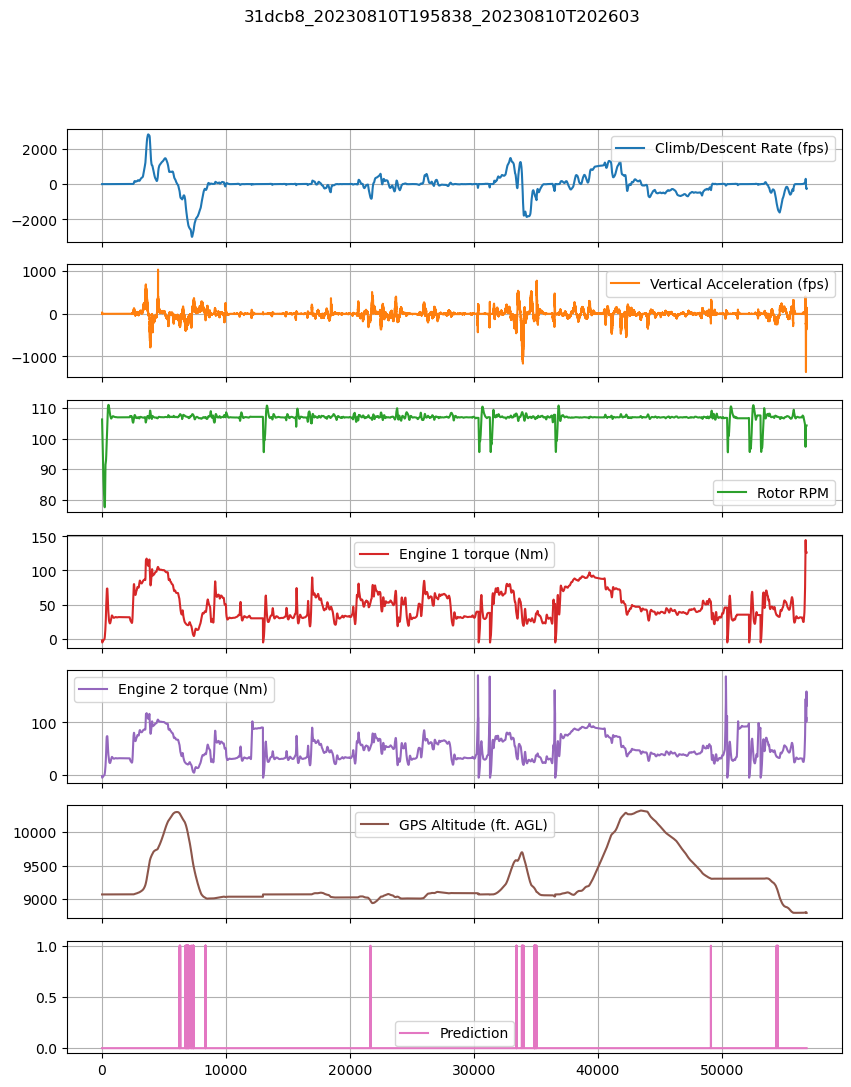

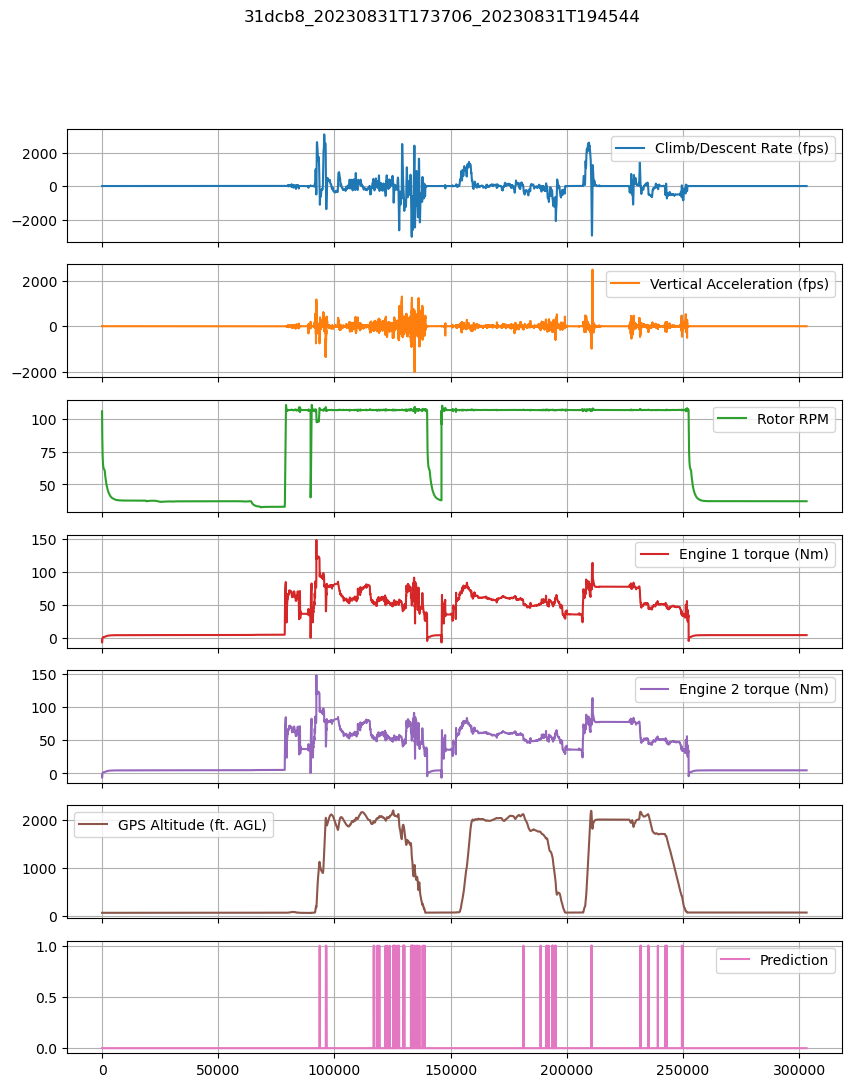

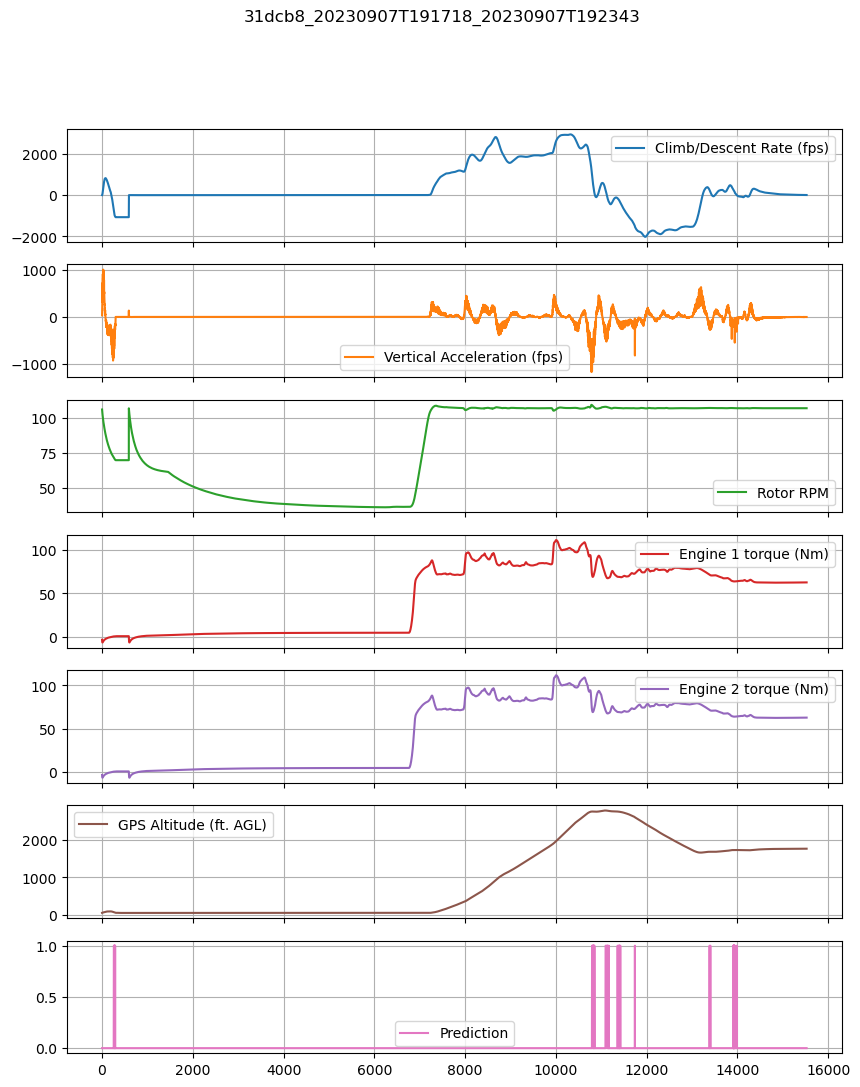

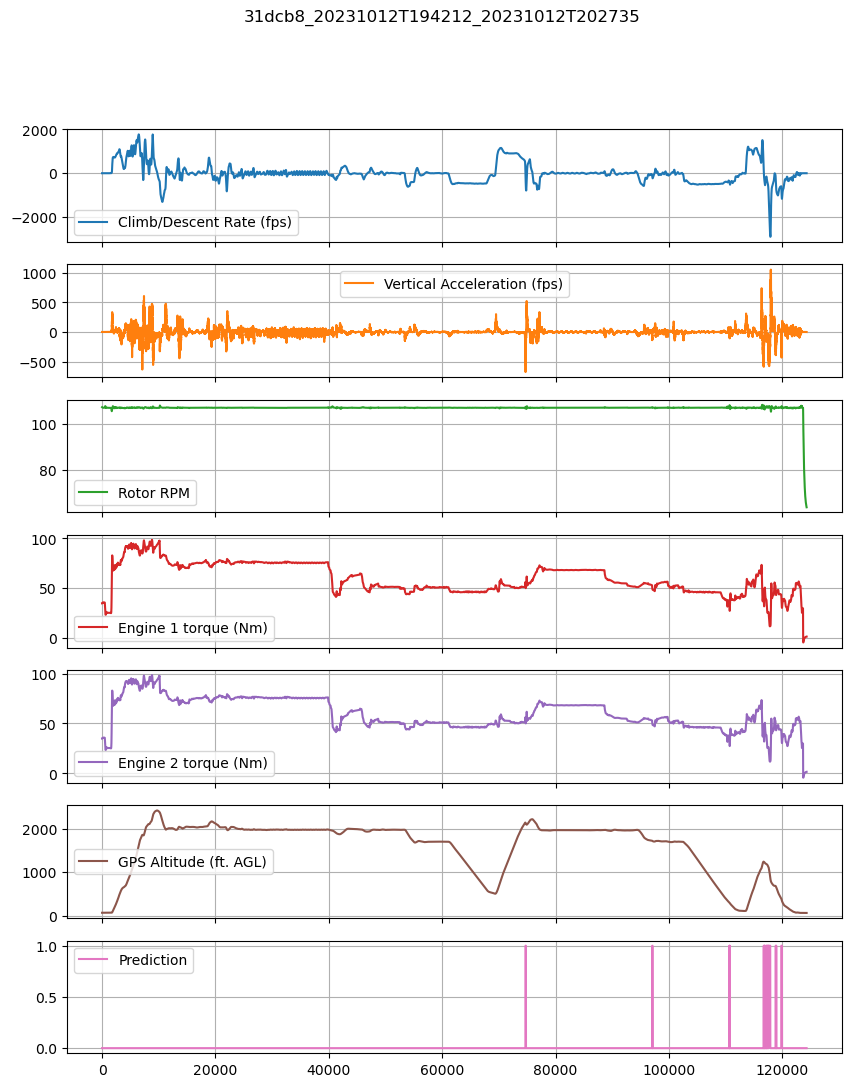

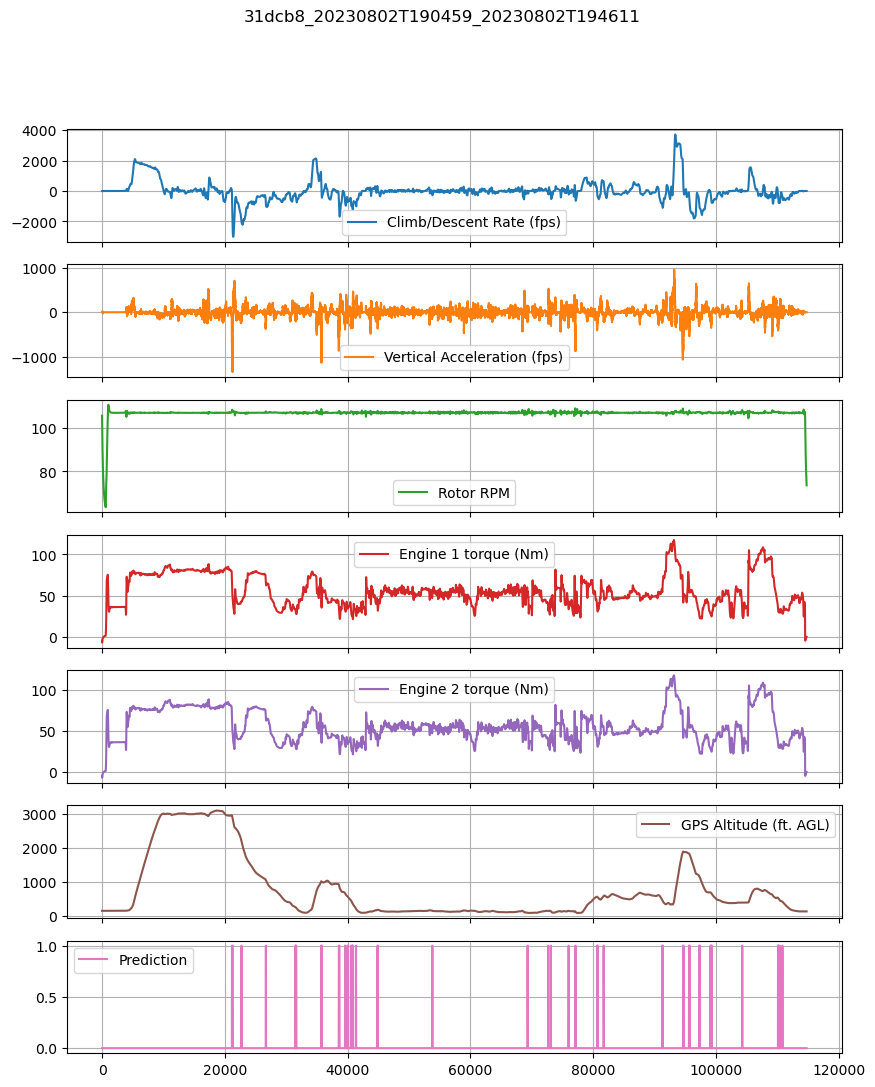

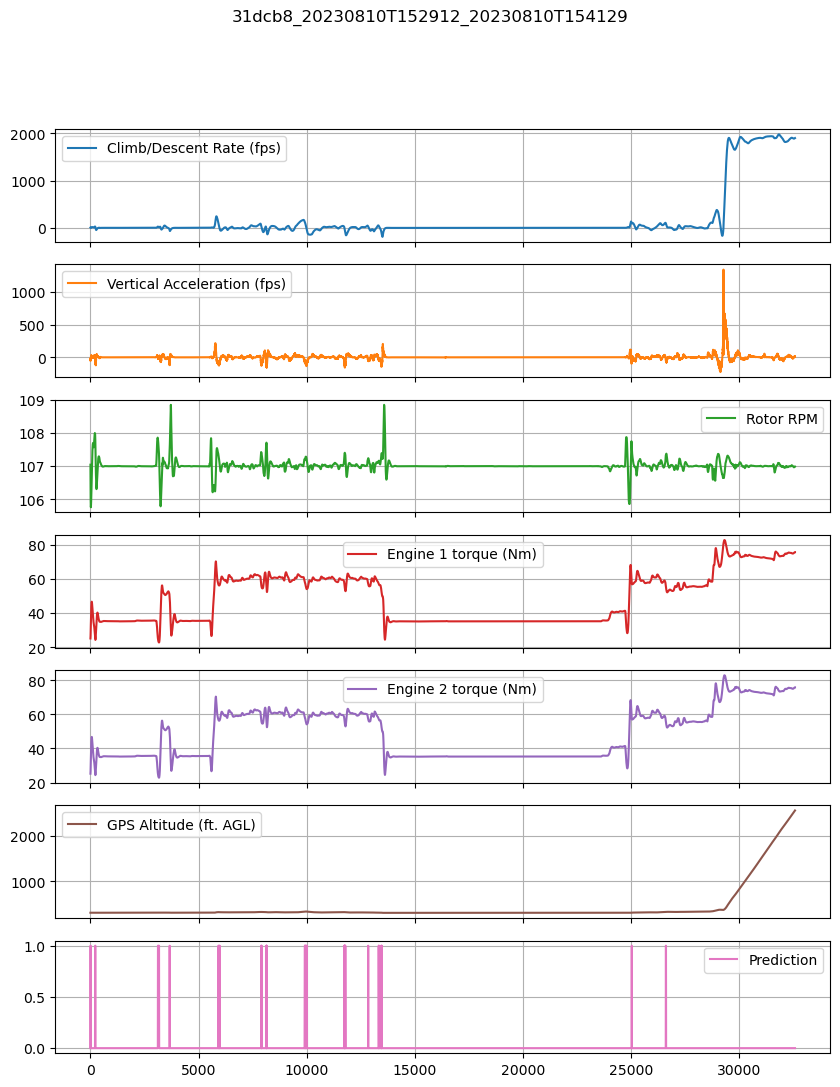

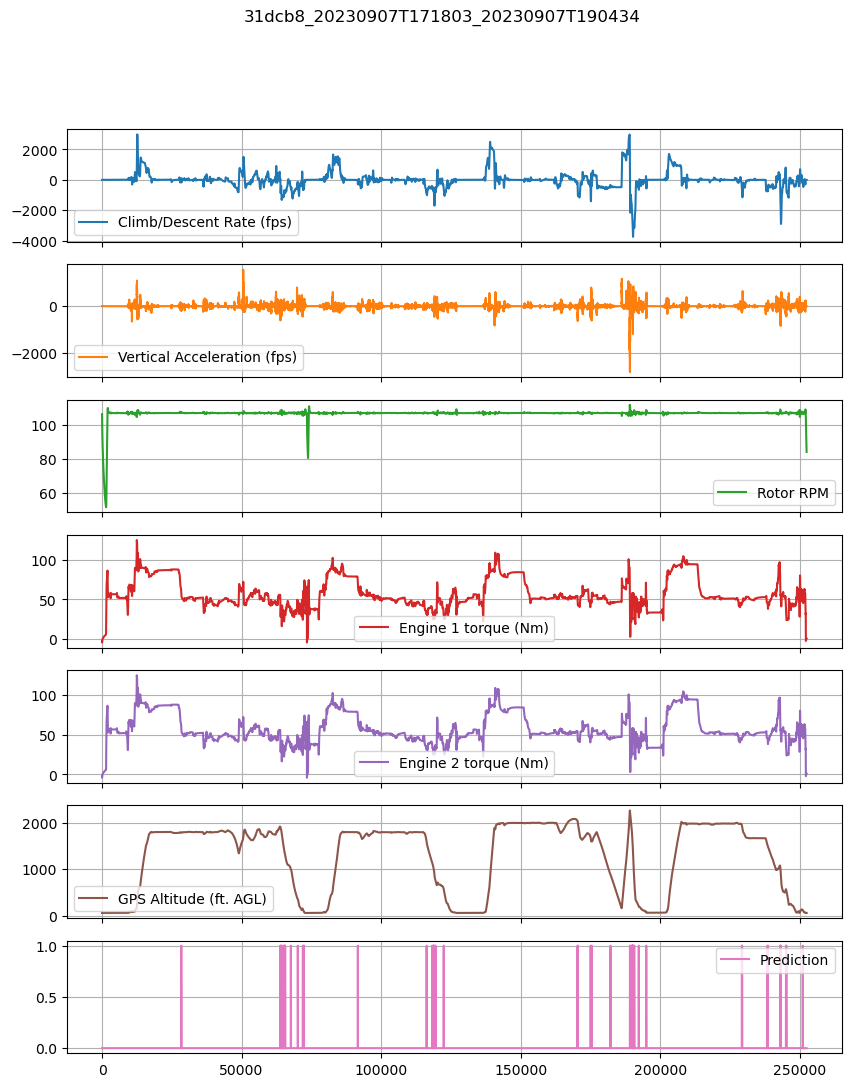

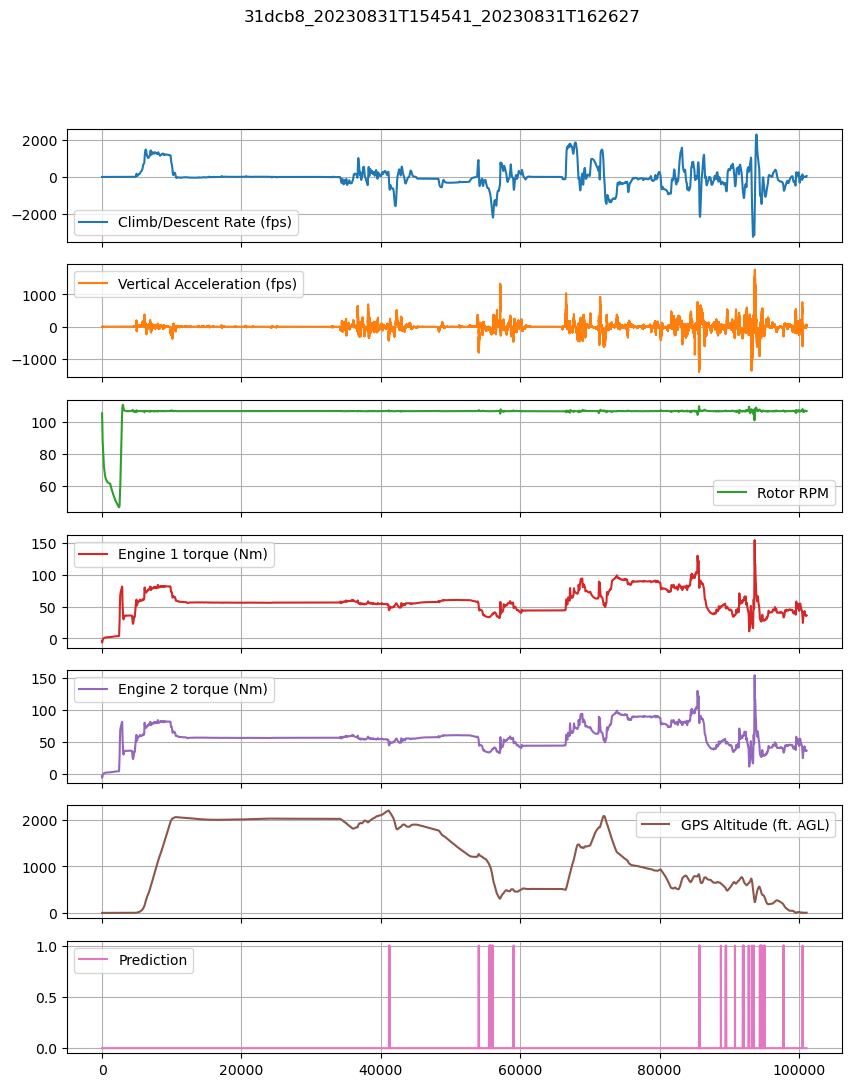

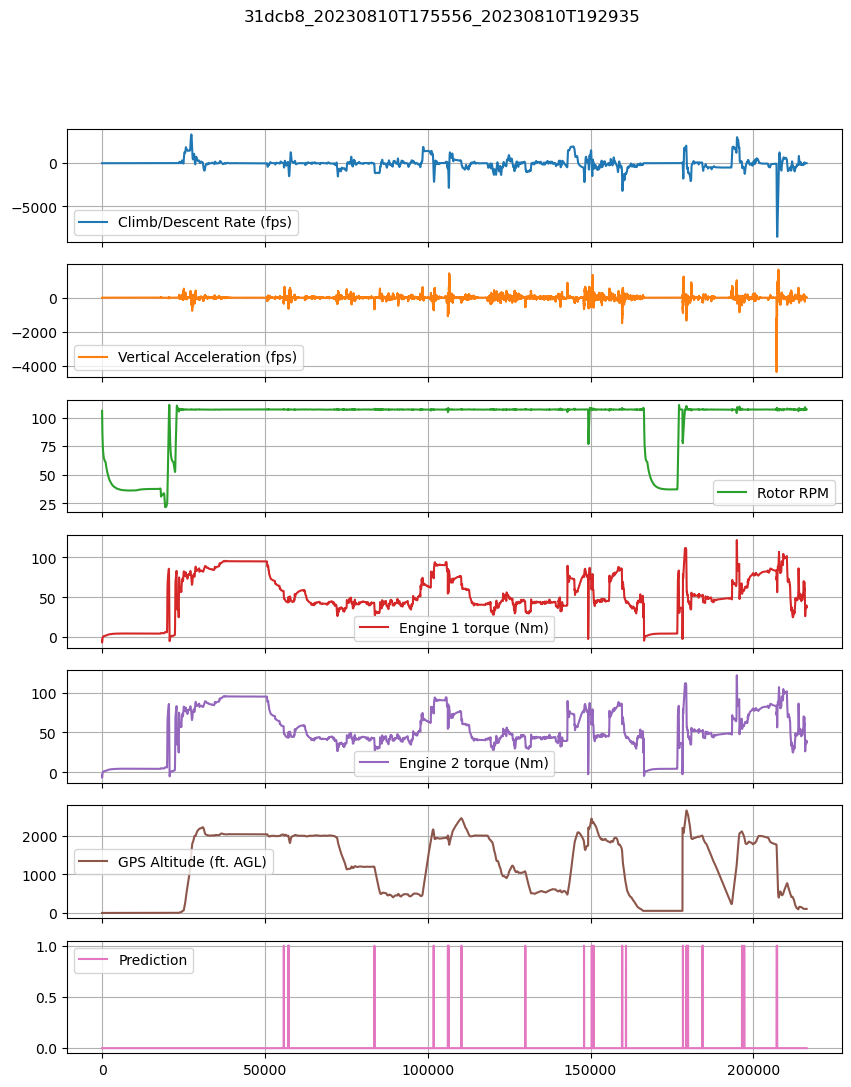

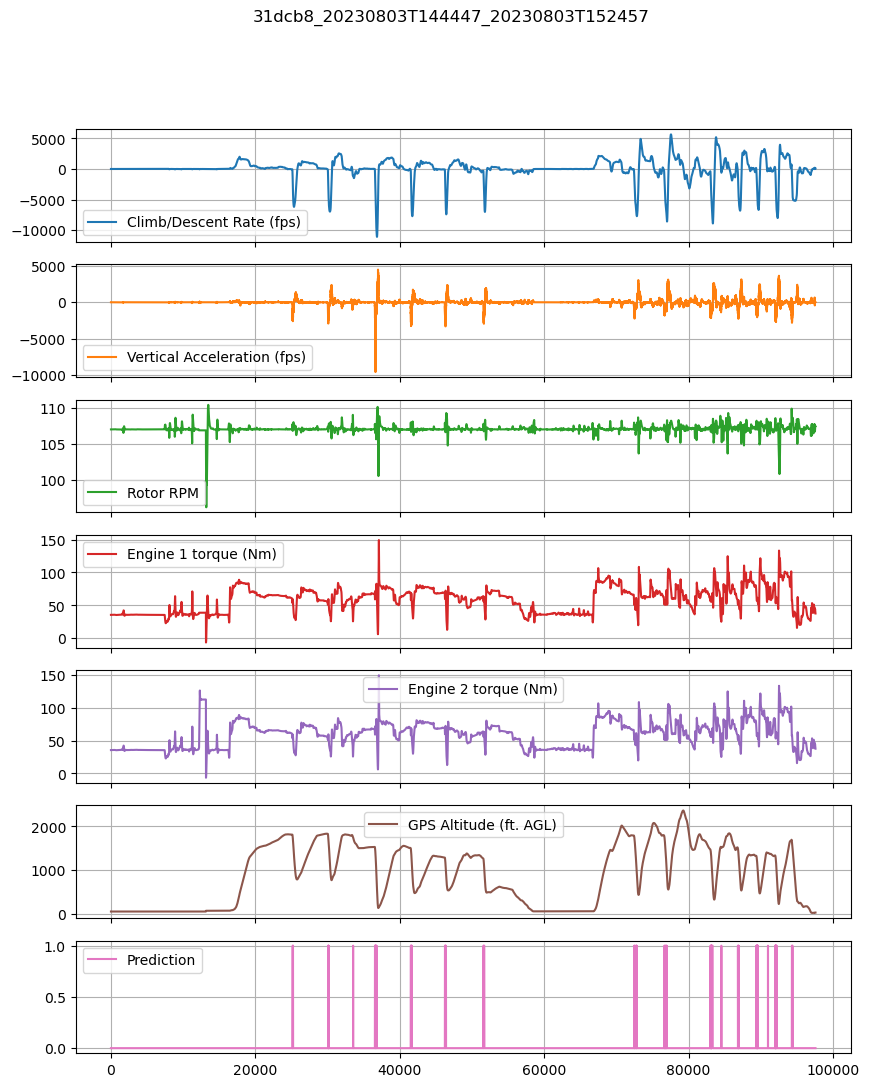

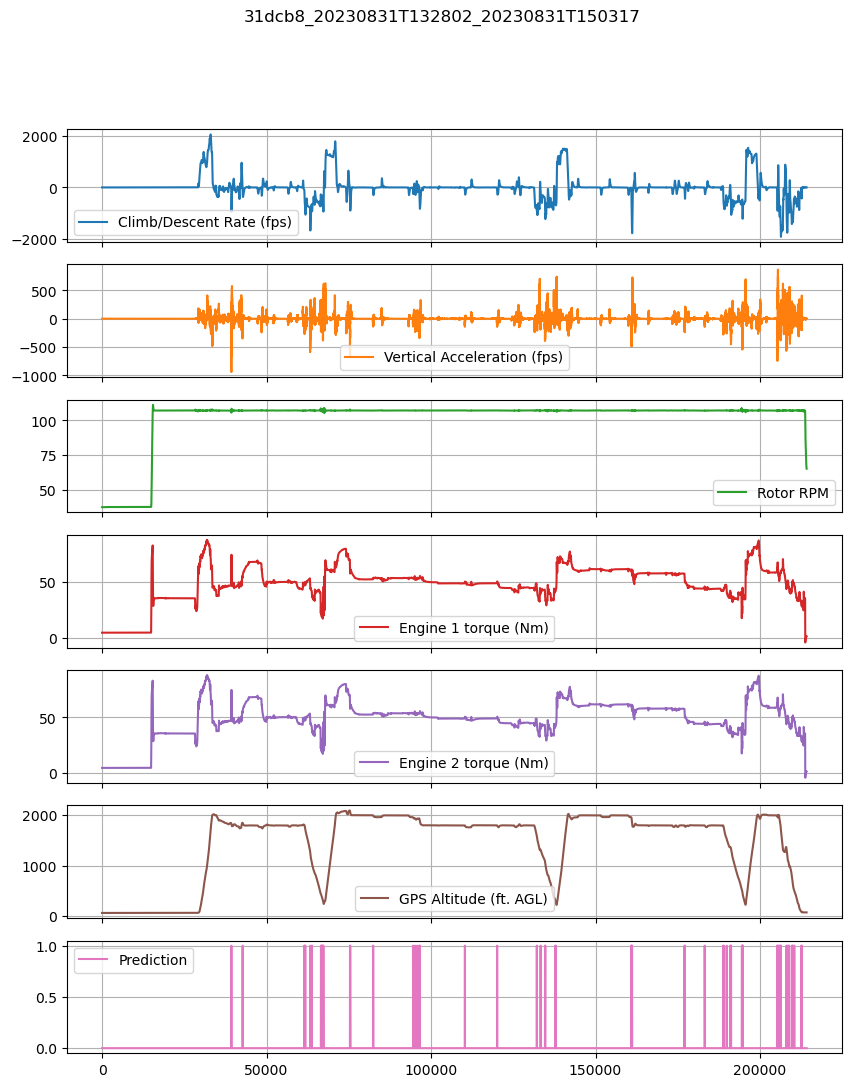

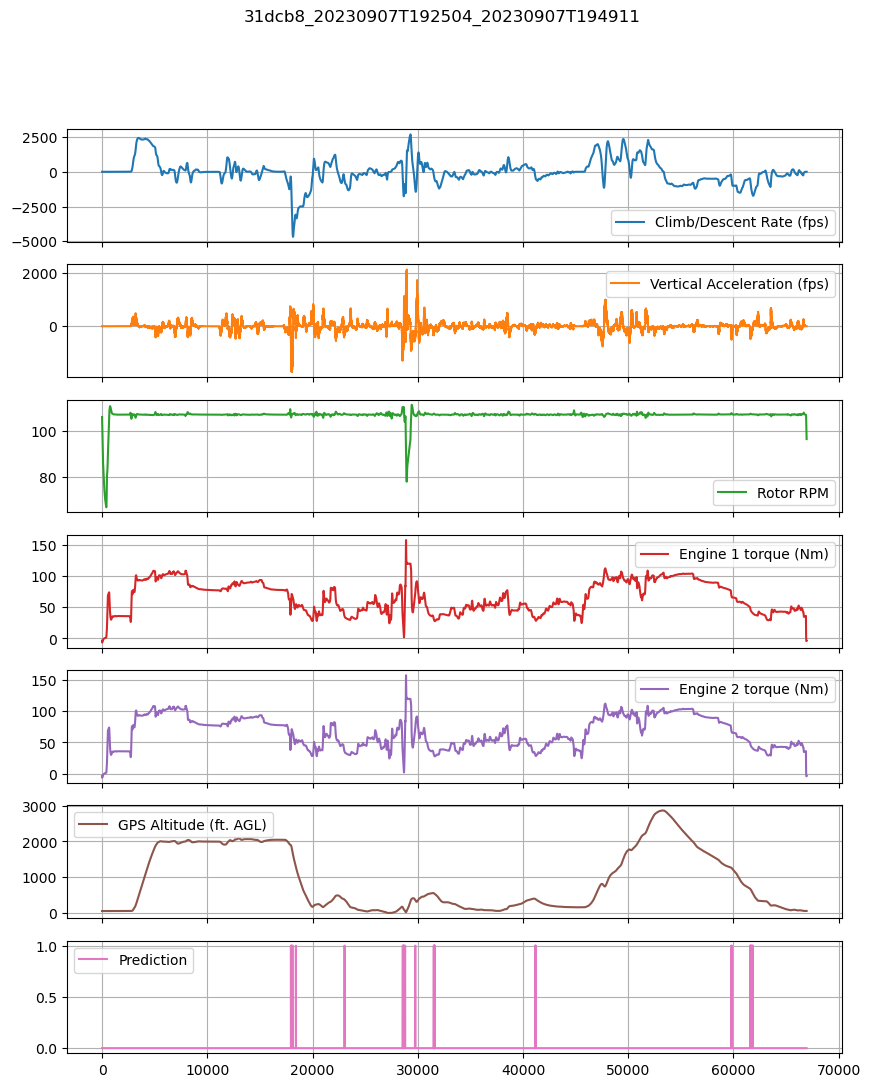

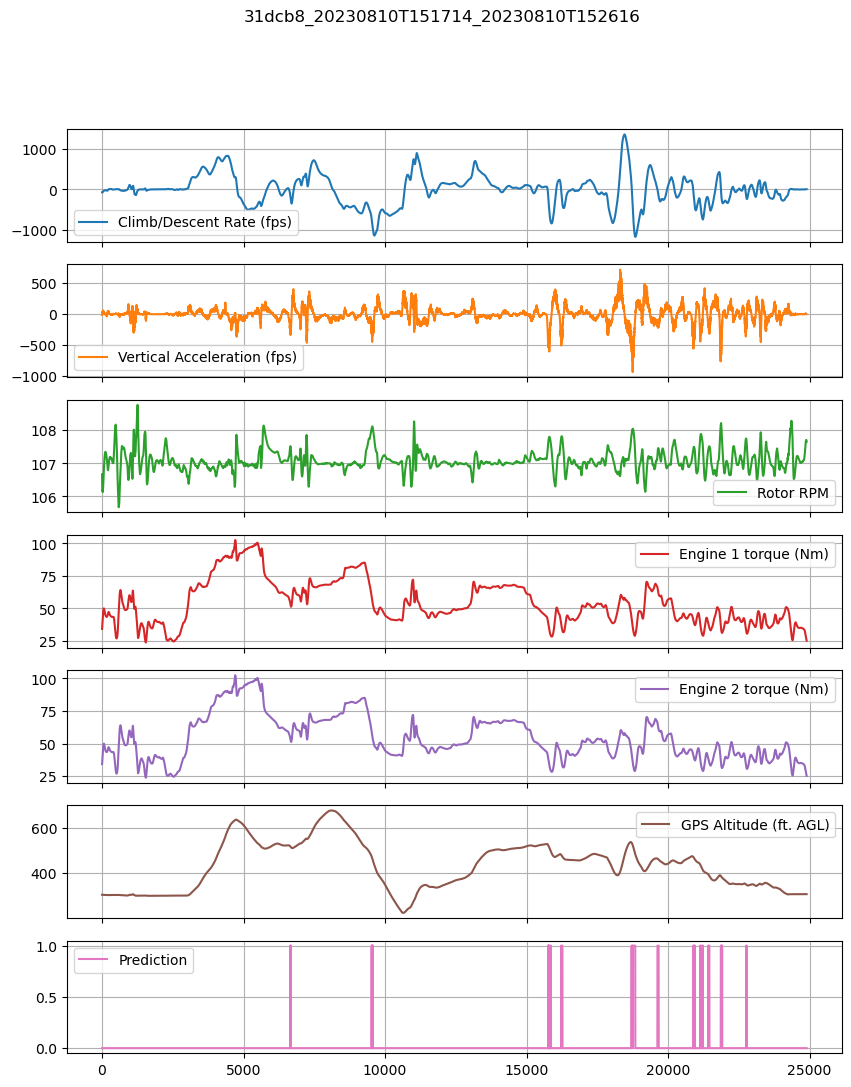

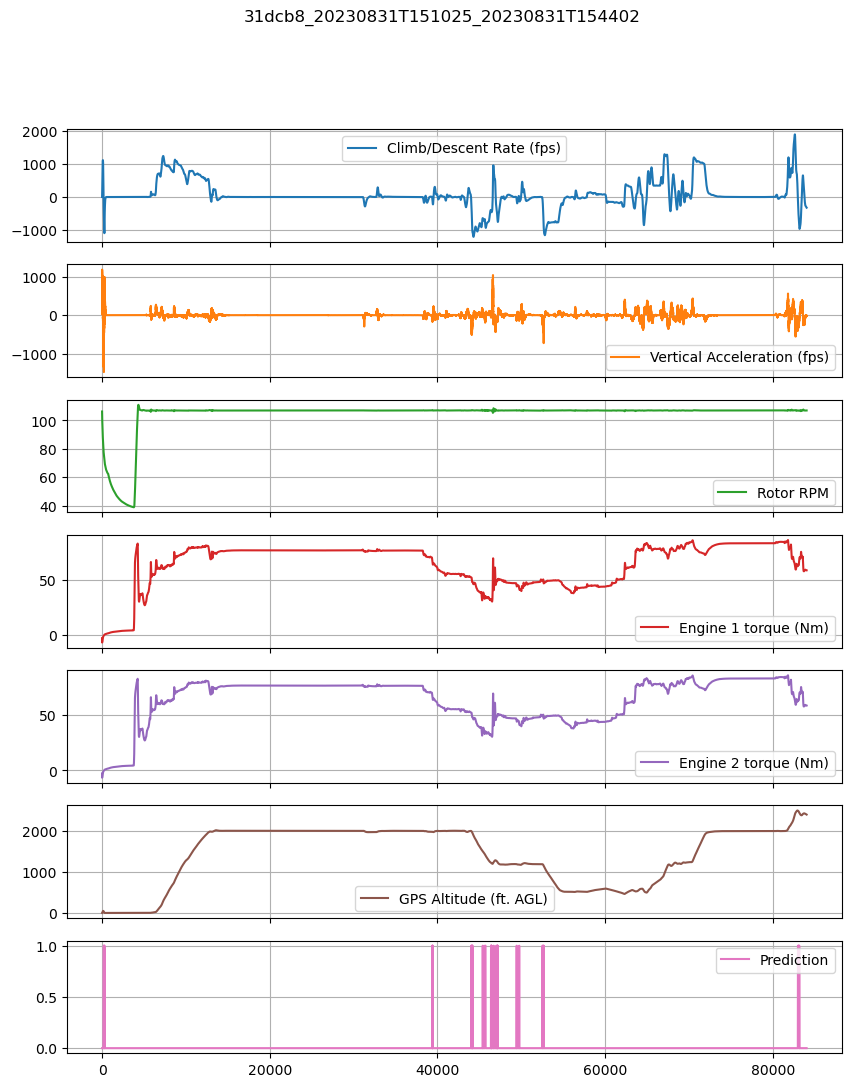

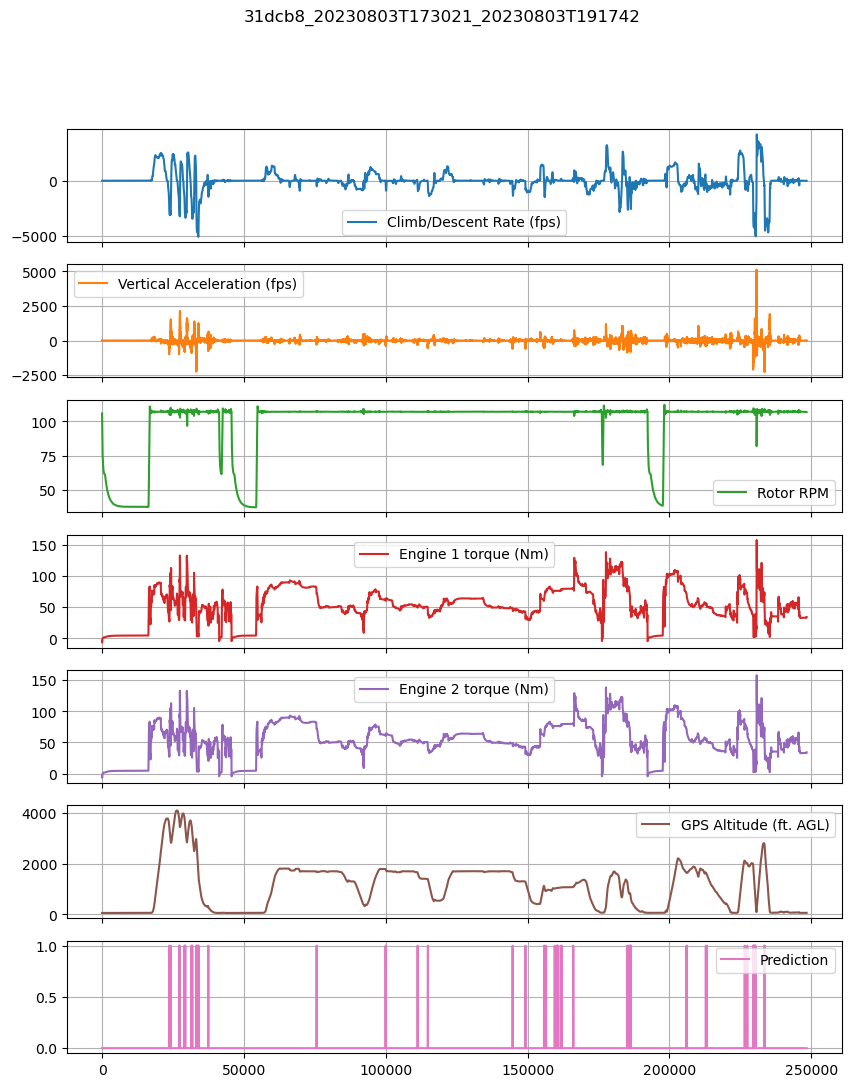

In [20]:
for flight in new_flights:
    predict_events(flight, clf)